In [1]:
#  1500x1500 사이즈 rmse, r2 비교하기 

import numpy as np
from osgeo import gdal
from sklearn.metrics import r2_score,mean_squared_error
from skimage.metrics import structural_similarity as ssim

In [6]:
# 이미지 불러오기
# 봄 20210323, 20221020
real_path = './Simulation_python/115-35_시각화/20210323_concatenate_subset.tif'
hien_path = './Simulation_python/115-35_시각화/20210323_hien.tif'
three_path = './Simulation_python/115-35_시각화/20210323_3by3.tif'
r2_path = './Simulation_python/115-35_시각화/20210323_r2.tif'

qa_path = './Landsat_image/115-35_original_qa_band/20210323_qa_pixel.tif'

pixel_value = [0,22080, 22280,24088, 24344, 24216, 24472, 30048,54596, 54852, 55052, 56856, 56984, 57240]

In [7]:
def img_to_array(img_path, qa_band=False):
    img_arr = gdal.Open(img_path)
    if qa_band:
        img_arr = img_arr.ReadAsArray()
        print(img_arr.shape)
        img_arr = img_arr[1:-1, 1:-1]
        img_arr = np.reshape(img_arr, (-1))
        return img_arr    
    else:
        img_arr = img_arr.ReadAsArray()
        img_arr = img_arr[:, 1:-1, 1:-1]
        img_arr = np.reshape(img_arr,  (len(img_arr), -1))
        return img_arr

def qa_band_remove(qa_data, pixel_value):
    qa_mask_index = np.isin(qa_data, pixel_value)
    return np.where(qa_mask_index)[0]

def arr_to_remove(img_arr, qa_arr):
    # 6개 밴드 qa_arr 제거
    for i in range(len(img_arr)):
        tmp_arr = np.delete(img_arr[i], qa_arr)

        if i == 0:
            return_arr = tmp_arr
        else:
            return_arr = np.vstack((return_arr, tmp_arr))
    
    return return_arr

def get_pixel_index(real_img):
    index_list = []
    for i in range(6):
        # 각 밴드마다의 7273 43636 구간의 index를 가져옴
        index = np.where((real_img[i] >= 7273) & (real_img[i] <= 43636))[0]
        index_list.append(index)
    return index_list

def extract_pixel_values(img_arr, index_range):
    extracted_values = []
    for i in range(len(img_arr)):
        band = img_arr[i]
        extracted_band = band[index_range[i]]
        extracted_values.append(extracted_band)
    return np.array(extracted_values)

real_img = img_to_array(real_path)
hien_img = img_to_array(hien_path)
three_img = img_to_array(three_path)
r2_img = img_to_array(r2_path)


qa_image = img_to_array(qa_path, qa_band=True)
qa_arr = qa_band_remove(qa_image, pixel_value)

real_img = arr_to_remove(real_img, qa_arr)
hien_img = arr_to_remove(hien_img, qa_arr)
three_img = arr_to_remove(three_img, qa_arr)
r2_img = arr_to_remove(r2_img, qa_arr)

invaild_pixel = get_pixel_index(real_img)

real_img = extract_pixel_values(real_img, invaild_pixel)
hien_img = extract_pixel_values(hien_img, invaild_pixel)
three_img = extract_pixel_values(three_img, invaild_pixel)
r2_img = extract_pixel_values(r2_img, invaild_pixel)

print(real_img.shape, hien_img.shape, three_img.shape, r2_img.shape) # r2_dtype_img.shape, landcover_img.shape

(1504, 1497)
(6,) (6,) (6,) (6,)


c:\Users\Lee\anaconda3\envs\gdal\lib\site-packages\ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


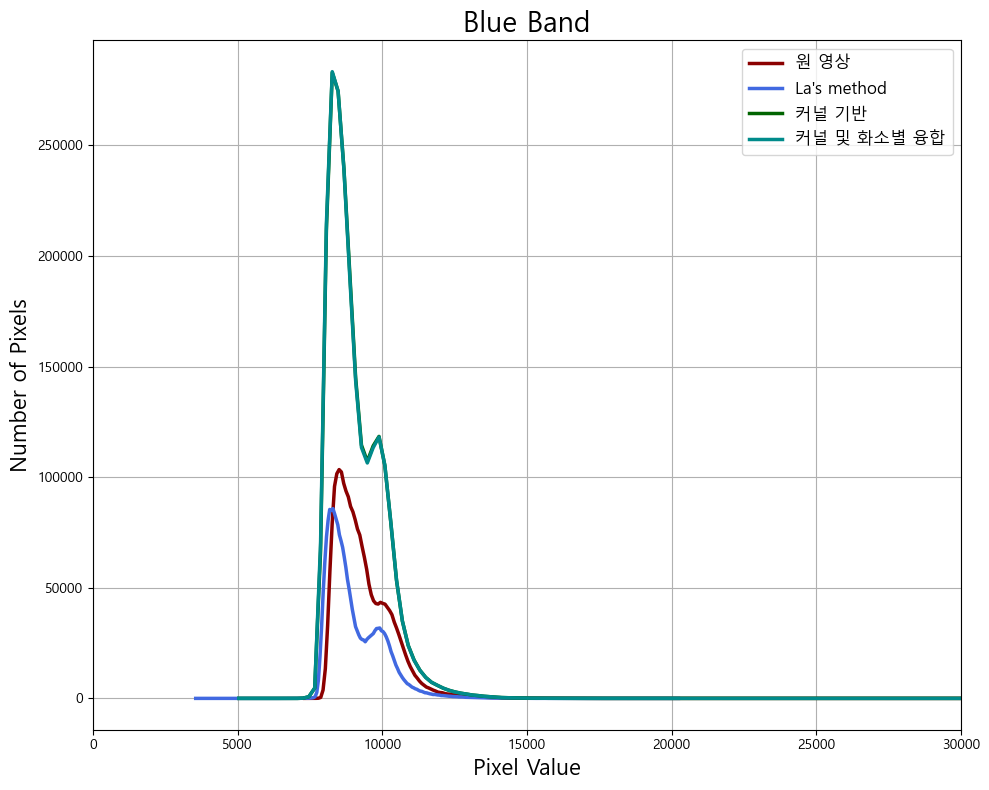

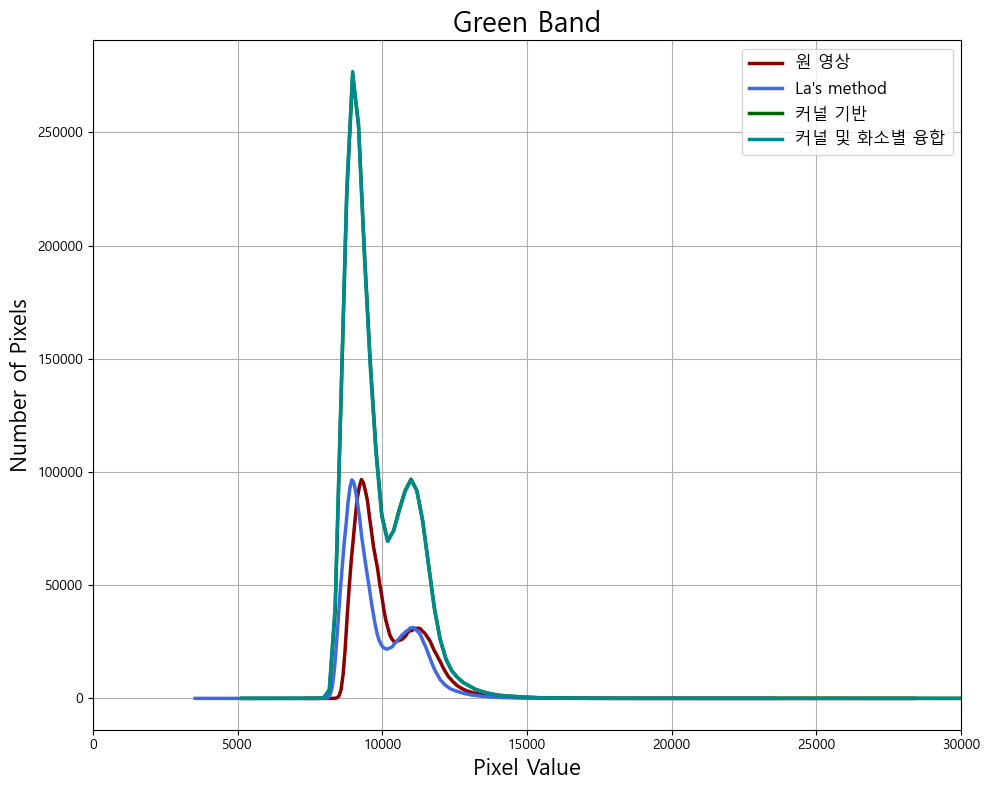

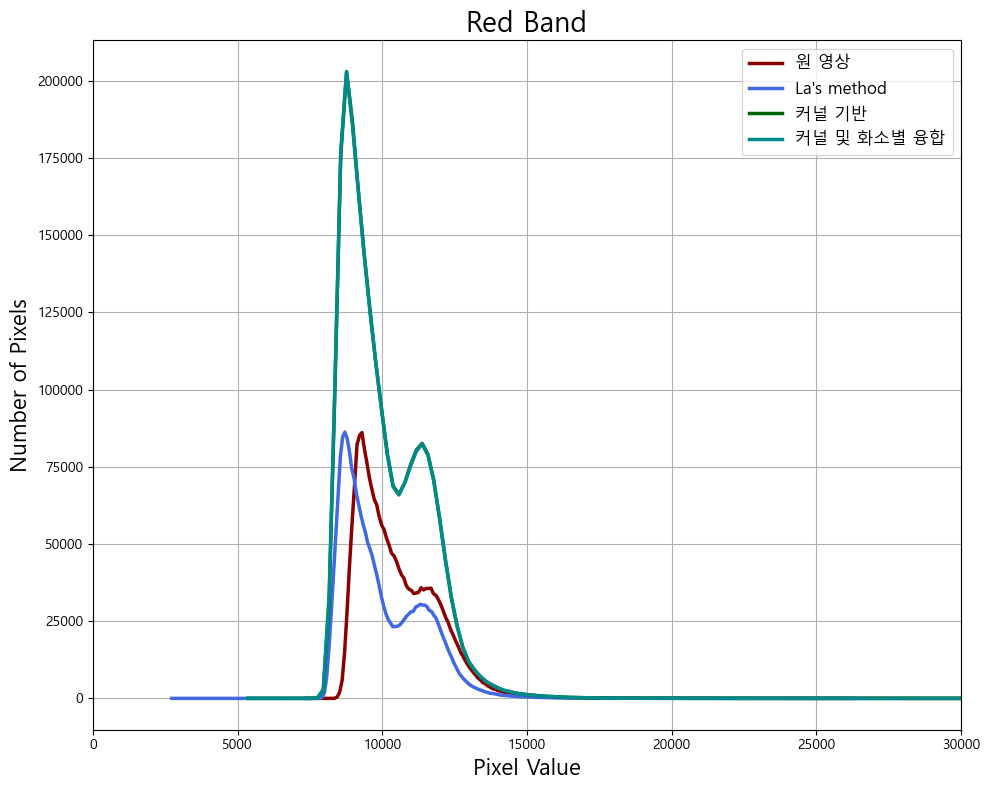

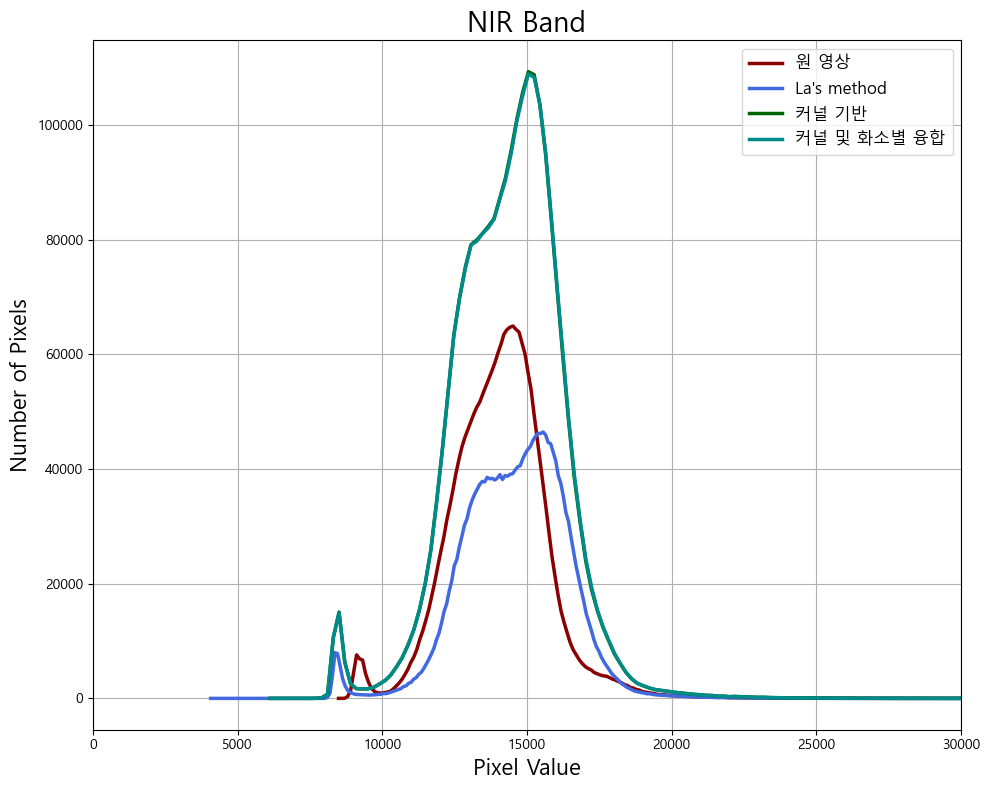

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# matplotlib의 폰트를 한글 폰트로 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_line_histogram_bandwise(images, labels, colors):
    titles = ["Blue Band", "Green Band", "Red Band", "NIR Band"]
    
    for idx, title in enumerate(titles):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        for img, label, color in zip(images, labels, colors):
            band_data = img[idx]
            hist, bins = np.histogram(band_data, bins=300)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            ax.plot(bin_centers, hist, label=label, color=color, linewidth=2.5)
        
        ax.legend(loc='upper right', fontsize=12)
        ax.set_title(title, fontsize=20)  # 제목 크기를 20으로 설정
        ax.set_xlabel('Pixel Value', fontsize=16)  # x축 라벨 크기를 16으로 설정
        ax.set_ylabel('Number of Pixels', fontsize=16)  # y축 라벨 크기를 16으로 설정
        ax.set_xlim(0, 30000)
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()

# 이미지 리스트, 라벨 리스트, 색상 리스트를 정의합니다.
images = [real_img, hien_img, three_img, r2_img]
labels = ['원 영상', "La's method", '커널 기반', '커널 및 화소별 융합']
colors = ['darkred', 'royalblue', 'darkgreen', 'darkcyan']

# 히스토그램을 그립니다.
plot_line_histogram_bandwise(images, labels, colors)


In [5]:
def plot_histogram_for_each_image(images, labels, colors):
    titles = ["Blue Band", "Green Band", "Red Band", "NIR Band"]
    
    for img, label in zip(images, labels):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        for idx, title in enumerate(titles):
            band_data = img[idx]
            hist, bins = np.histogram(band_data, bins=300)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            ax.plot(bin_centers, hist, label=title, color=colors[idx], linewidth=2.5)
        
        ax.legend(loc='upper right', fontsize=12)
        ax.set_title(f"{label} 히스토그램", fontsize=16)
        ax.set_xlabel('Pixel Value', fontsize=14)
        ax.set_ylabel('Number of Pixels', fontsize=14)
        ax.set_xlim(0, 30000)
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()

# 이미지 리스트와 라벨 리스트를 정의합니다.
images = [real_img, hien_img, three_img, r2_img]
labels = ['원 영상', 'La"s method', '커널 기반', '커널 및 화소별 융합']
colors = ['darkred', 'royalblue', 'darkgreen', 'darkcyan']

# 각 이미지별로 히스토그램을 그립니다.
plot_histogram_for_each_image(images, labels, colors)


NameError: name 'plt' is not defined

In [24]:
from sklearn.metrics import mean_squared_error

# 영상 테두리 제거 전 3x3 선택 부분 
# 모든 픽셀 기준 
for i in range(4):
    # 각 밴드에 대한 데이터 추출
    print("band  : ", i+2)
    
    real_band = real_img[i]
    hien_band = hien_img[i]
    three_band = three_img[i]
    r2_band = r2_img[i]
    land_band = land_band[i]
    # 모든 픽셀 기준
    # same_r2_hien_indices = np.where(slide_r2_band == slide_hien_band)[0]
    same_r2_three_indices = np.where(r2_band == three_band)[0]

    # 해당하는 인덱스를 사용하여 값을 추출
    et_real_band = real_band[same_r2_three_indices]
    et_three_band = three_band[same_r2_three_indices]
    et_r2_band = r2_band[same_r2_three_indices]
    et_hien_band = hien_band[same_r2_three_indices]
    et_land_band = land_band[same_r2_three_indices]

    print(et_real_band.shape, et_three_band.shape, et_r2_band.shape, et_hien_band.shape)

    # 상관 계수 계산
    corr_coef_hien = np.corrcoef(et_real_band.flatten(), et_hien_band.flatten())[0, 1]
    corr_coef_three = np.corrcoef(et_real_band.flatten(), et_three_band.flatten())[0, 1]
    corr_coef_r2 = np.corrcoef(et_real_band.flatten(), et_r2_band.flatten())[0, 1]
    corr_coef_land = np.corrcoef(et_real_band.flatten(), et_r2_band.flatten())[0, 1]

    # 출력
    print("RMSE, Correlation Coefficient (hien):", mean_squared_error(et_real_band, et_hien_band)**0.5, corr_coef_hien)
    print("RMSE, Correlation Coefficient (three):", mean_squared_error(et_real_band, et_three_band)**0.5, corr_coef_three)
    print("RMSE, Correlation Coefficient (r2):", mean_squared_error(et_real_band, et_r2_band)**0.5, corr_coef_r2)
    print("RMSE, Correlation Coefficient (land):", mean_squared_error(et_real_band, et_land_band)**0.5, corr_coef_land)
    
    

band  :  2


IndexError: invalid index to scalar variable.

In [16]:

def slide_img_to_array(img_path, qa_band=False):
    img_arr = gdal.Open(img_path)
    if qa_band:
        img_arr = img_arr.ReadAsArray()
        print(img_arr.shape)
        img_arr = img_arr[1:-1, 1:-1]
        img_arr = np.reshape(img_arr, (-1))
        return img_arr    
    else:
        img_arr = img_arr.ReadAsArray()
        img_arr = img_arr[:, 1:-1, 1:-1]
        img_arr = np.reshape(img_arr,  (len(img_arr), -1))
        return img_arr

def slide_qa_band_remove(qa_data, pixel_value):
    qa_mask_index = np.isin(qa_data, pixel_value)
    return np.where(qa_mask_index)[0]

def slide_arr_to_remove(img_arr, qa_arr):
    # 6개 밴드 qa_arr 제거
    for i in range(len(img_arr)):
        tmp_arr = np.delete(img_arr[i], qa_arr)

        if i == 0:
            return_arr = tmp_arr
        else:
            return_arr = np.vstack((return_arr, tmp_arr))
    
    return return_arr

slide_real_img = slide_img_to_array(real_path)
slide_hien_img = slide_img_to_array(hien_path)
slide_three_img = slide_img_to_array(three_path)
slide_r2_img = slide_img_to_array(r2_path)

slide_r2_dtype_img = slide_img_to_array(landcover_path)

slide_qa_image = slide_img_to_array(qa_path, qa_band=True)
slide_qa_arr = slide_qa_band_remove(slide_qa_image, pixel_value)

slide_real_img = slide_arr_to_remove(slide_real_img, slide_qa_arr)
slide_hien_img = slide_arr_to_remove(slide_hien_img, slide_qa_arr)
slide_three_img = slide_arr_to_remove(slide_three_img, slide_qa_arr)
slide_r2_img = slide_arr_to_remove(slide_r2_img, slide_qa_arr)
slide_r2_dtype_img = slide_arr_to_remove(slide_r2_dtype_img, slide_qa_arr)

print(slide_real_img.shape, slide_hien_img.shape, slide_three_img.shape, slide_r2_img.shape, slide_r2_dtype_img.shape) # r2_dtype_img.shape, landcover_img.shape

(1504, 1497)
(6, 2245310) (6, 2245310) (6, 2245310) (6, 2245310) (6, 2245310)


In [17]:
# 모든 픽셀 기준 
for i in range(4):
    # 각 밴드에 대한 데이터 추출
    print("band  : ", i+2)
    
    slide_real_band = slide_real_img[i]
    slide_hien_band = slide_hien_img[i]
    slide_three_band = slide_three_img[i]
    slide_r2_band = slide_r2_img[i]
    slide_r2_dtype_band = slide_r2_dtype_img[i]

    slide_hien_corr_coef = np.corrcoef(slide_real_band.flatten(), slide_hien_band.flatten())[0,1]
    slide_three_corr_coef = np.corrcoef(slide_real_band.flatten(), slide_three_band.flatten())[0,1]
    slide_r2_corr_coef = np.corrcoef(slide_real_band.flatten(), slide_r2_band.flatten())[0, 1]
    slide_r2_dtype_corr_coef = np.corrcoef(slide_real_band.flatten(), slide_r2_dtype_band.flatten())[0,1]

    print("rmse, r2, ssim (hien) : ", mean_squared_error(slide_real_band, slide_hien_band)**0.5, slide_hien_corr_coef, ssim(slide_real_band, slide_hien_band, data_range=real_band.max()-real_band.min()))
    print("rmse, r2, ssim (3by3) : ", mean_squared_error(slide_real_band, slide_three_band)**0.5, slide_three_corr_coef, ssim(slide_real_band, slide_three_band, data_range=real_band.max()-real_band.min()))
    print("rmse, r2, ssim (r2) : ", mean_squared_error(slide_real_band, slide_r2_band)**0.5, slide_r2_corr_coef, ssim(slide_real_band, slide_r2_band, data_range=real_band.max()-real_band.min()))
    print("rmse, r2, ssim (r2_dtype) : ", mean_squared_error(slide_real_band, slide_r2_dtype_band)**0.5, slide_r2_dtype_corr_coef, ssim(slide_real_band, slide_r2_dtype_band, data_range=real_band.max()-real_band.min()))
    


band  :  2
rmse, r2, ssim (hien) :  173.9422425936295 0.9609029541663917 0.9777221968277882
rmse, r2, ssim (3by3) :  174.81001825632077 0.9316813639440817 0.9557739903174877
rmse, r2, ssim (r2) :  173.814391974122 0.9576369570513792 0.9753326712700382
rmse, r2, ssim (r2_dtype) :  177.09076475918775 0.9101797964407299 0.9624971370229226
band  :  3
rmse, r2, ssim (hien) :  173.82963210412925 0.9673162443466051 0.9747008121129768
rmse, r2, ssim (3by3) :  173.93372294512992 0.9442223286081912 0.9486049235573171
rmse, r2, ssim (r2) :  173.59830427634603 0.9642857614185526 0.9714556593898401
rmse, r2, ssim (r2_dtype) :  178.45231702755564 0.9179789143984377 0.9517305680931653
band  :  4
rmse, r2, ssim (hien) :  177.34484337631835 0.9604835774472523 0.9613142553435186
rmse, r2, ssim (3by3) :  177.30127305840875 0.9306739477690419 0.9220714284362811
rmse, r2, ssim (r2) :  177.20880458861993 0.9577026542328557 0.9578851522338854
rmse, r2, ssim (r2_dtype) :  177.126823629768 0.9073467325591064 0

In [35]:
from sklearn.metrics import mean_squared_error

# 3x3 선택 픽셀 기준  영상 테두리 제거 후 
for i in range(4):
    # 각 밴드에 대한 데이터 추출
    print("band  : ", i+2)
    
    slide_real_band = slide_real_img[i]
    slide_hien_band = slide_hien_img[i]
    slide_three_band = slide_three_img[i]
    slide_r2_band = slide_r2_img[i]
    slide_r2_dtype_band = slide_r2_dtype_img[i]

    same_r2_three_indices = np.where(slide_r2_band == slide_three_band)[0]
    # 해당하는 인덱스를 사용하여 값을 추출
    extracted_real_band = slide_real_band[same_r2_three_indices]
    extracted_three_band = slide_three_band[same_r2_three_indices]
    extracted_r2_band = slide_r2_band[same_r2_three_indices]
    extracted_hien_band = slide_hien_band[same_r2_three_indices]

    print(extracted_hien_band.shape, extracted_three_band.shape, extracted_real_band.shape, extracted_r2_band.shape)
    # RMSE 계산
    rmse_three = mean_squared_error(extracted_real_band, extracted_three_band) ** 0.5
    rmse_hien = mean_squared_error(extracted_real_band, extracted_hien_band) ** 0.5
    rmse_r2 = mean_squared_error(extracted_real_band, extracted_r2_band) ** 0.5

    # 상관 계수 계산
    corr_coef_three = np.corrcoef(extracted_real_band.flatten(), extracted_three_band.flatten())[0, 1]
    corr_coef_hien = np.corrcoef(extracted_real_band.flatten(), extracted_hien_band.flatten())[0, 1]
    corr_coef_r2 = np.corrcoef(extracted_real_band.flatten(), extracted_r2_band.flatten())[0, 1]

    # 출력
    print("RMSE, Correlation Coefficient (hien):", rmse_hien, corr_coef_hien, r2_score(extracted_real_band, extracted_hien_band))
    print("RMSE, Correlation Coefficient (three):", rmse_three, corr_coef_three, r2_score(extracted_real_band, extracted_three_band))
    print("RMSE, Correlation Coefficient (r2):", rmse_r2, corr_coef_r2, r2_score(extracted_real_band, extracted_r2_band))

band  :  2
(1105023,) (1105023,) (1105023,) (1105023,)
RMSE, Correlation Coefficient (hien): 123.26856225557815 0.944890064874843 0.9839234668780299
RMSE, Correlation Coefficient (three): 133.52337697498857 0.9192104330913426 0.9811373653178536
RMSE, Correlation Coefficient (r2): 133.52337697498857 0.9192104330913426 0.9811373653178536
band  :  3
(1138291,) (1138291,) (1138291,) (1138291,)
RMSE, Correlation Coefficient (hien): 130.77378218390908 0.9475543225095315 0.9878808750073395
RMSE, Correlation Coefficient (three): 144.09594398333994 0.9240227292858162 0.9852859099776856
RMSE, Correlation Coefficient (r2): 144.09594398333994 0.9240227292858162 0.9852859099776856
band  :  4
(1049391,) (1049391,) (1049391,) (1049391,)
RMSE, Correlation Coefficient (hien): 145.97591744890272 0.9531242500628906 0.9910085582969282
RMSE, Correlation Coefficient (three): 160.8213856263186 0.9300141745528789 0.9890867399199578
RMSE, Correlation Coefficient (r2): 160.8213856263186 0.9300141745528789 0.989

In [36]:
from sklearn.linear_model import LinearRegression

# 회귀 모델 훈련
X = [[1, 2], [2, 3], [3, 4]]  # 다중 특성 데이터
y = [3, 4, 5]  # 타깃 데이터
model = LinearRegression()
model.fit(X, y)

# 회귀 계수 확인
coefficients = model.coef_
intercept = model.intercept_
print("회귀 계수:", coefficients)
print("절편:", intercept)

회귀 계수: [0.5 0.5]
절편: 1.5000000000000004
